<a href="https://colab.research.google.com/github/jegraham/Phase-1-Basic-GNN/blob/InMemoryDataset/Graham%2C_Jessica_Simple_GNN_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GNN Implementation (Phase 1) 

This is the initial GNN implementation using encoders and decoders. 


## Import Libraries

In [6]:
import os
import shutil # -> For copying a directory 
import pandas as pd # -> For data structure and file manipulation

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [7]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html

#from torch_geometric.datasets import Planetoid ## --> Replace with InMemoryDataset
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit
import torch.nn.functional as F
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

2.0.1+cu118
Using cuda.
Found existing installation: torch-scatter 2.1.1+pt20cu118
Uninstalling torch-scatter-2.1.1+pt20cu118:
  Successfully uninstalled torch-scatter-2.1.1+pt20cu118
Found existing installation: torch-sparse 0.6.17+pt20cu118
Uninstalling torch-sparse-0.6.17+pt20cu118:
  Successfully uninstalled torch-sparse-0.6.17+pt20cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.1
Uninstalling torch-cluster-1.6.1:
  Successfully uninstalled torch-cluster-1.6.1
uninstall
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

Check GPU

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 26 23:03:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check Memory

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [10]:
# Import the Data
from google.colab import files 
uploaded = files.upload()
# uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

file_name = next(iter(uploaded))
df = pd.read_csv(file_name)

df.to_csv('/content/data.csv', index=False)
df = df.reset_index(drop=True)# Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

Saving May 4th Dataset Car and Tower  - Sheet1.csv to May 4th Dataset Car and Tower  - Sheet1.csv


# Setup Dataset 


In [31]:
# Generate a graph
# Inspirations taken from - Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

# Create an empty graph and lists
G = nx.Graph()
edge_index = []


# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])


# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'], errors='coerce')

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor


# add nodes to the graph with their features 
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph 
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)
        
        if 0 < dist <= 500:
          distances.append((dist, j))
        # print(distance)

   distances.sort()
        
   for k in range(len(distances)):
       G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)


[(0, 276), (0, 6), (0, 190), (0, 237), (0, 198), (0, 275), (0, 269), (0, 59), (0, 166), (0, 142), (0, 256), (0, 131), (0, 90), (0, 60), (0, 228), (0, 221), (0, 149), (0, 137), (0, 86), (0, 70), (0, 291), (0, 25), (0, 67), (0, 85), (0, 83), (0, 26), (0, 51), (0, 267), (1, 12), (1, 57), (1, 250), (1, 225), (1, 183), (1, 79), (1, 27), (1, 235), (1, 8), (1, 174), (1, 105), (1, 247), (1, 173), (1, 99), (1, 47), (1, 53), (1, 207), (1, 62), (1, 39), (1, 245), (2, 178), (2, 293), (2, 159), (2, 124), (2, 265), (2, 309), (2, 44), (2, 14), (2, 263), (2, 261), (2, 156), (2, 220), (2, 17), (2, 157), (2, 253), (2, 249), (2, 117), (2, 209), (2, 298), (2, 76), (2, 103), (2, 187), (2, 23), (2, 289), (2, 177), (2, 128), (2, 301), (2, 55), (2, 91), (2, 122), (2, 78), (2, 61), (2, 162), (2, 163), (2, 260), (2, 134), (2, 274), (3, 243), (3, 75), (3, 303), (3, 214), (3, 116), (3, 255), (3, 112), (3, 41), (3, 72), (3, 155), (3, 239), (3, 73), (3, 296), (3, 95), (3, 223), (3, 37), (3, 252), (4, 229), (4, 136)

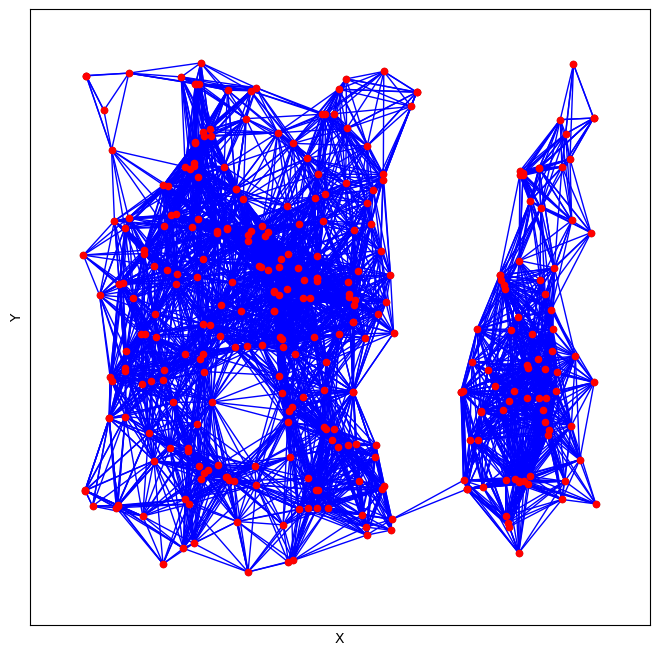

In [32]:
# Plotting Graph (Version 1)
X = df[['X', 'Y']].values

# create a layout for the graph nodes
pos = dict(zip(range(len(df)), X))

# draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['X'], df['Y'], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='b', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()


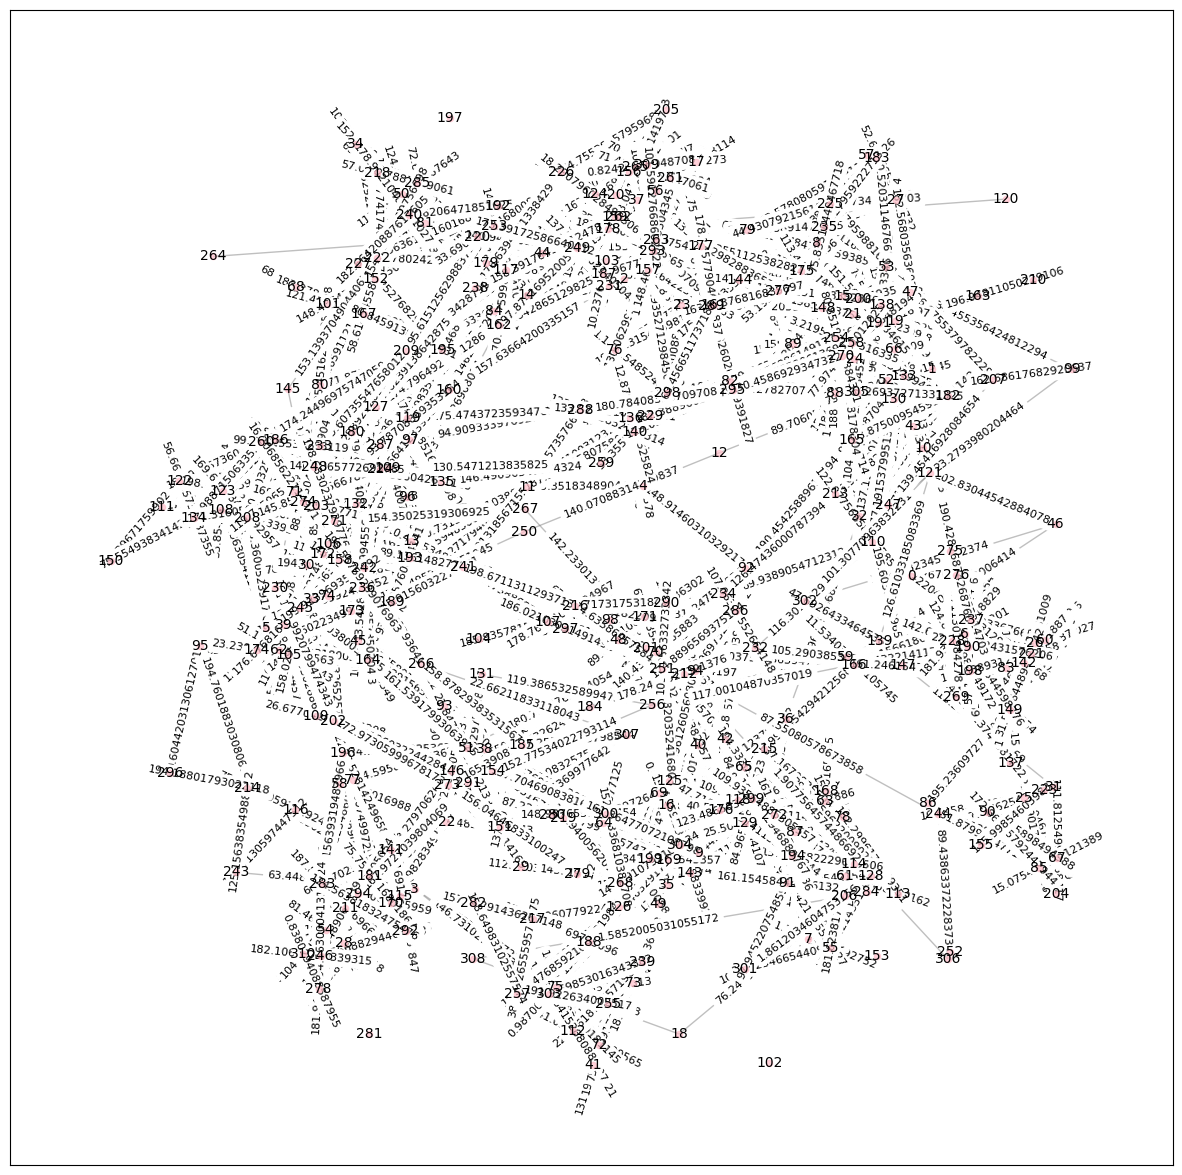

In [23]:
# Plotting Graph (Version 2)

# generate a layout for the graph nodes
pos = nx.spring_layout(G, k=1.1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))


# draw the nodes of the graph
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='pink', alpha=0.7, edgecolors='pink')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# draw the edges of the graph
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# get the edge weights as a dictionary
edge_labels = nx.get_edge_attributes(G, 'weight')

# draw the edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# display the graph

plt.show()

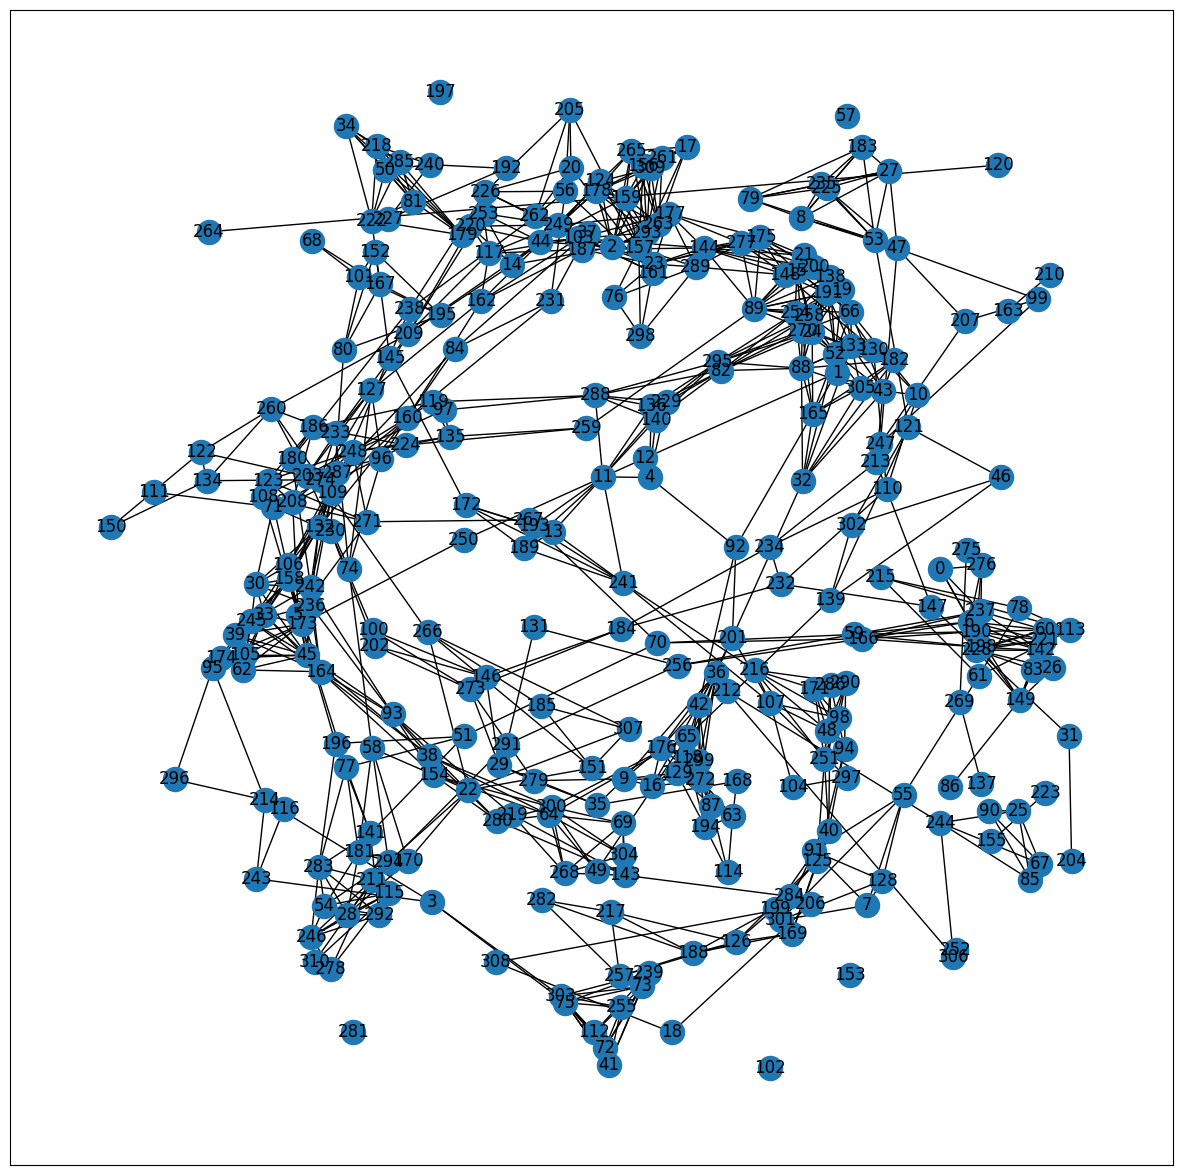

Graph with 311 nodes and 926 edges


In [24]:
# Plotting Graph (Version 3)
# Displaying the Graph Edges Similar 

# specify node positions
pos = nx.spring_layout(G,k=1, iterations=50, seed=42) 
fig, ax = plt.subplots(figsize=(15, 15))

# draw nodes
nx.draw_networkx_nodes(G, pos) 

# draw node labels
nx.draw_networkx_labels(G, pos)

# draw edges
nx.draw_networkx_edges(G, pos)  


plt.show() 

print(G)

# CONVERT Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [46]:
#InMemoryDataset
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name     
        super(MyDataset, self).__init__(root, transform, pre_transform)
        out = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return os.path.join(self.root, 'raw')

    @property
    def  processed_dir(self):
        return os.path.join(self.root, 'processed')
        # name = f'processed{"_cleaned" if self.cleaned else ""}'
        # return osp.join(self.root, self.filename, name)

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
       return ['data.pt']

    
    def download(self):
        self.path = os.path.join(root, file_name)
        self.df = pd.read_csv(self.path)
        self.df.to_csv(self.path, index=False)


    def process(self):
        # Perform necessary preprocessing, feature extraction, etc., on the data
        # You need to transform your data into the appropriate format for PyTorch Geometric
        G = nx.Graph()
        
        edge_index = []
        edge_source = []
        edge_target = []

        # Convert 'Car ID' column to numeric values 
        # Assign numeric IDs based on 'Car ID' column
        self.df['Car ID'] = pd.to_numeric(self.df['Car ID'], errors='coerce')
        car_ids = torch.tensor(self.df['Car ID'].values, dtype=torch.float)
        vertex = car_ids  # Use 'Car ID' as the vertex tensor

       
        # iterate through rows and add nodes to the graph
        for i in range(len(self.df)):
            G.add_node(i, x=self.df.loc[i, 'X'], y=self.df.loc[i, 'Y'])

        # add nodes to the graph with their features
        for i, row in self.df.iterrows():
            G.add_node(i, **row.to_dict())
            edge_index.append([row['X'], row['Y']])

        # Loop row by row to add the edges to the graph 
        for i in range(len(self.df)):
          distances = []

          # Inner loop to iterate through all other vehicles
          for j in range(len(self.df)): 
                edge_source = torch.tensor([i]) 
                edge_target = torch.tensor([j])

                if i == j:
                    continue
                dist = math.sqrt((self.df.iloc[j]['X']-self.df.iloc[i]['X'])**2 + (self.df.iloc[j]['Y']-self.df.iloc[i]['Y'])**2)
                if 0 < dist <= 500:
                  distances.append((dist, j))

          distances.sort()
                
          for k in range(min(3, len(distances))):
              G.add_edge(i, distances[k][1], weight=distances[k][0])

        # Create PyTorch Geometric Data object
        self.data = Data(
            x=torch.tensor(edge_source, dtype=torch.float),  
            y=torch.tensor(edge_target),
            edge_index=torch.tensor(edge_index).t().contiguous() 
       )
        
        self.data, self.slices = self.collate([data])
        torch.save(self.data, os.path.join(self.processed_dir, self.processed_paths[0]))


# Define the root directory where the dataset will be stored
root = './'
file_name = 'data.csv'
dest = os.path.join(root, file_name)

dataset = MyDataset(root,file_name)


# Access the dataset using the `dataset` variable
# For example, you can access the first graph's node features and labels as follows:
print('Done')
# x = data['x']
# y = data['y']
# edge_index = data['edge_index']

# ### Display the graph here 
# # Convert the PyTorch Geometric data to a NetworkX graph
# G = nx.Graph()
# if i in data:
#         G.add_node(i, pos=(x[i].item(), y[i].item()))
# G.add_edges_from(edge_index.t().tolist())

# # Plot the graph based on x and y coordinates
# pos = nx.get_node_attributes(G, 'pos')
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos, with_labels=True)
# plt.show()

Processing...
<ipython-input-46-451ebcd557be>:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(edge_source, dtype=torch.float),
<ipython-input-46-451ebcd557be>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(edge_target),


NameError: ignored

## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
    T.ToDevice(device)])

# My Dataset code
dataset = MyDataset(root, file_name, transform)
train_data, val_data, test_data = dataset[0]


Step 3 INIT
4 - DataFrame 
Data Frame
    Car ID            X            Y
0    RSU 1   900.000000   900.000000
1    RSU 2  3300.000000   900.000000
2    RSU 3   900.000000  2500.000000
3    RSU 4  3300.000000  2500.000000
4    RSU 5  1600.000000  1600.000000
..     ...          ...          ...
306    296   262.577682   943.846324
307    297   480.406939  1938.562423
308    298  2374.866031  2859.839327
309    299   965.998015  2617.177235
310    300   415.717731  1289.906995

[311 rows x 3 columns]
5 - Raw
5 - Download
Processed Directory
Processed Directory
6 - Processed
Processed Directory
6 - Processed
Processed Directory
6 - Processed
Processed Directory
6 - Processed
Processed Directory
3
3
3
Step 3 INIT
4 - DataFrame 
Data Frame
    Car ID            X            Y
0    RSU 1   900.000000   900.000000
1    RSU 2  3300.000000   900.000000
2    RSU 3   900.000000  2500.000000
3    RSU 4  3300.000000  2500.000000
4    RSU 5  1600.000000  1600.000000
..     ...          ...        

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:183: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:183: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

### Define the Autoencoder

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 2
num_features = data.num_features #### RESUME - May 18th
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
positive_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

get_item 2
6 - Processed
Processed Directory


AttributeError: ignored

In [ ]:
def train():
    model.train()
    print('1')
    optimizer.zero_grad()
    print('2')
    z = model.encode(x, train_pos_edge_index)
    print('3')
    loss = model.recon_loss(z, train_pos_edge_index)
    print('4')
    if args.variational:
      print('5')
      loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    print('6')
    optimizer.step()
    print('7')
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    print('8')
    with torch.no_grad():
        print('9')
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z

## Are the results (AUC) and (AP) easy to read and compare?

# Use Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# parameters
out_channels = 2
num_features = dataset.num_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Import tensorboard

#### Installation: (if needed) "pip install tensorboard"

In [ ]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

## Graph Variational AutoEncoder (GVAE)

In [ ]:
from torch_geometric.nn import VGAE
!pip install --verbose torch-scatter

In [ ]:
dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [ ]:
out_channels = 2
num_features = dataset.num_features
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
writer = SummaryWriter('runs/VGAE_experiment_'+'2d_100_epochs')

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line